# Intro to Reinforcement Learning

In this assignment you will learn the basics of reinforcement learning (RL), as well how to train a DQN RL model.

A lot of this information, text, and code is directly pooled from the following sources

Credits:
* Hugging Face Deep RL course [source](https://huggingface.co/learn/deep-rl-course/unit0/introduction)
* Gymnasium-Colaboratory-Starter [source](https://github.com/hom-bahrani/Gymnasium-Colaboratory-Starter)
* PyTorch RL Tutorials [source](https://pytorch.org/tutorials/)
* Wikipedia RL Page [source](https://en.wikipedia.org/wiki/Reinforcement_learning)

First, install and import the packages and libraries you will need throughout this exercise

In [102]:
# install gymnasium packages
%pip install gymnasium
%pip install gymnasium[classic-control]
%pip install swig

# install virtual display packages
%pip install pyvirtualdisplay
%pip install moviepy
%pip install --upgrade moviepy

# install stable baselines3
%pip install stable-baselines3

# install snntorch
%pip install snntorch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [103]:
# Update the Package Index
!sudo apt update --quiet

# Install xvfb
!sudo apt-get install -y xvfb --quiet

Hit:1 https://packages.microsoft.com/repos/microsoft-ubuntu-focal-prod focal InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 https://dl.yarnpkg.com/debian stable InRelease
Hit:6 https://repo.anaconda.com/pkgs/misc/debrepo/conda stable InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]
Hit:2 https://packagecloud.io/github/git-lfs/ubuntu focal InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1504 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [4149 kB]
Fetched 5780 kB in 1s (3949 kB/s)
Reading package lists...
Building dependency tree...
Reading state information...
28 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...
Building dependency tree...
Reading state information...
xvfb is already the new

In [104]:
# gymnasium imports
import gymnasium as gym
from gymnasium.wrappers.record_video import RecordVideo

# video imports
import glob
import uuid
import io
import base64
from IPython.display import HTML
# from IPython import display as ipythondisplay

# ml imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# plot imports
import matplotlib
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display as ipythondisplay


# utility imports
import os
import math
import random
import shutil
import random
from itertools import count
from collections import namedtuple, deque

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The first time you install these packages you have to restart the kernel to ensure they work correctly. Run the following `kill()` function kill the kernel and then manually restart it. Afterwards, feel free to comment it out on subsequent runs.

In [105]:
# os.kill(os.getpid(), 9)

## 1. What is Reinforcement Learning?

<img src="images/RL_process.jpg" width="800" height="500">

Along with Supervised Learning and Unsupervised Learning, Reinforcement Learning is one of the 3 basic machine learning paradigms. The idea behind Reinforcement Learning is that an agent (an AI) will learn from the environment by interacting with it (through trial and error) and receiving rewards (negative or positive) as feedback for performing actions.

You can think of it like playing a video game where you get points for collecting coins and you lose points for getting hit by enemies. This "trains" you to collect coins, while avoiding enemies. Of course, games get a lot more complicated than that which is why one of the main challenges of RL is figuring out how to reward or punish the agent. That is to say, we use the [carrot and the stick](https://en.wikipedia.org/wiki/Carrot_and_stick).

The diagram describing how a RL agent interacts with a environment can be interpretated as such:

1. The Agent/Model/AI receives a **state $S_t$** (the info the agent receieves from the environment at time t)
2. Based on that **state** $S_t$ the agent takes an *action* $A_t$
3. The environment goes to a new **state** $S_{t+1}$
4. The environment gives some **reward** $R_{t+1}$ to the agent
5. repeat


### 1.1 Defining Cumulative Reward

The reward is fundamental in RL because it’s the only feedback for the agent. Thanks to it, our agent knows if the action taken was good or not.

Where
* $R()$: `Return` is the cumulative reward function
* $\tau$: `Trajectory` represented by *tau* is a sequence of `states` and `actions`
* $\gamma$: `Discount Rate` represented by *gamma* between 0-1
* $r_t$: `reward` at time step t

The cumulative reward is represented by the function

$R(\tau) = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \gamma^3 r_{t+4} + ...$

or 

$R(\tau) = \sum_{k=0}^{\infty} \gamma^k r_{t+k+1}$

An important insight here is that $\gamma$ is exponentiated, this means a smaller $\gamma$ causes a bigger `discount` and rewards at farther timesteps are `discounted` more. So, the smaller the $\gamma$ the less the agent cares more about closer/short-term rewards, and the bigger $\gamma$ the more the agent cares about farther/long-term rewards.

### 1.2 Defining Policy

You can think of `policy`, $\pi$, as the mind of the agent

This `policy` is the function we want to learn, our goal is to find the `optimal policy` $\pi^*$, the policy that maximizes expected return when the agent acts according to it. We find this $\pi^*$ through training. 

Note: $\pi^*$ is pronounced "pie-star" and in algorithms "*" (star) often denotes optimality

There are two types of policies:

1. Deterministic: a policy at a given state will always return the same action.
    * $\pi(s) = a$
2. Stochastic: outputs a probability distribution over actions.
    * $\pi(a|s) = P[A|s]$
        * $|$ means given
        * $P[]$ means probability distribution
        * $P[A|s]$ means a probability distribution over a set of actions given a state

There are two approaches to **train** our agent to find this optimal policy π*:

1. Directly, by teaching the agent to learn which action to take, given the current state: **Policy-Based Methods**.
2. Indirectly, teach the agent to learn which state is more valuable and then take the action that leads to the more valuable states: **Value-Based Methods**.



## 2. Creating an Environment

Now that you understand what a Reinforcement Learning agent is and does. Lets create an environment for our prospective RL agent to interact with.

To do that we will be using the environment library [Gymnasium](https://gymnasium.farama.org/) which was developed by OpenAI and handed off to the Farama Foundation to maintain and update.

*GitHub codespaces doesn't have an inbuilt display, create a virtual display instead.*

In [106]:
# install a virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

The first virtual environment you will be using is the `'CartPole-v1'` environment. This is a virtual version of the real life Cart Pole/Inverted Pendulum task, here is a short fun [video](https://youtu.be/nOSTzpA0nGk?si=mFYYwhLhTb5hcrpB) for you to see.

### 2.1 Understanding Gymnasium
Remember that at each step:
- Our Agent receives a **state ($S_0$)** from the **Environment** — i.e. we receive the first frame of our game (Environment).
- Based on that **state ($S_0$),** the Agent takes an **action ($A_0$)** — i.e. our Agent will move to the right.
- The environment transitions to a **new** **state ($S_1$)** — i.e. new frame.
- The environment gives some **reward ($R_1$)** to the Agent — i.e. we’re not dead *(Positive Reward +1)*.


With Gymnasium:

1. We create our environment using `gymnasium.make()`
2. We reset the environment to its initial state with `observation = env.reset()`

At each step:

3. Get an action using our model (in our example we take a random action)
4. Using `env.step(action)`, we perform this action in the environment and get
    - `observation`: The new state ($s_{t+1}$)
    - `reward`: The reward we get after executing the action
    - `terminated`: Indicates if the episode terminated (agent reach the terminal state)
    - `truncated`: Introduced with this new version, it indicates a timelimit or if an agent go out of bounds of the environment for instance.
    - `info`: A dictionary that provides additional information (depends on the environment).

For more explanations check this -> https://gymnasium.farama.org/api/env/#gymnasium.Env.step

If the episode is terminated:
- We reset the environment to its initial state with `observation = env.reset()`

#### 2.2 Task Types
There are two types of task: `Episodic Tasks` and `Continuous Tasks`

1. Episodic Task
    - In this case, we have a starting point and an ending point (a terminal state). This creates an episode: a list of States, Actions, Rewards, and new States.
2. Continuous task
    - These are tasks that continue forever (no terminal state). In this case, the agent must learn how to choose the best actions and simultaneously interact with the environment.
    - For instance, an agent that does automated stock trading. For this task, there is no starting point and terminal state. The agent keeps running until we decide to stop it.


## Question 1  &emsp; <span style="color:green">(1 Point)</span>

In gymnasium the environments are set up as episodic tasks. A good practice is to look at documentation before using an environment to know its properties. If `'CartPole-v1'` is episodic, that means it must have termination conditions. List `'CartPole-v1'`'s termination conditions below.

Link to documentation -> https://gymnasium.farama.org/environments/classic_control/cart_pole/ 

<span style="color:green">Answer</span>

<span style="color:red">

1. Termination: Pole Angle is greater than ±12°

2. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)

3. Truncation: Episode length is greater than 500 (200 for v0)

</span>

#### 2.3 Default Properties of Gymnasium's Cart Pole environment 

##### **Action Space (The set of possible actions of the model)**

The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

0: Push cart to the left

1: Push cart to the right

Note: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

##### **Observation Space (The subset of the state the actor observes)**

The observation is a ndarray with shape (4,) with the values corresponding to the following positions and velocities:

<img src="images/observation_space.png" width="700" height="200">

##### **Rewards**

Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted. The threshold for rewards is 500 for v1 and 200 for v0.


In [107]:
# How to access the above values
env = gym.make("CartPole-v1")
env.reset()
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space Shape", env.observation_space.shape)
print("Sample observation", env.observation_space.sample()) # Get a random observation
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # Take a random action

_____OBSERVATION SPACE_____ 

Observation Space Shape (4,)
Sample observation [-4.0825200e+00  1.1261091e+38 -8.9522198e-02  1.9340669e+37]

 _____ACTION SPACE_____ 

Action Space Shape 2
Action Space Sample 1


#### 2.4 Gymnasium Interactive Loop

Below is the code for a simple interactive loop where instead of a agent predicting a action we simply sample a random action. Look at what happens to the cartpole when random actions are chosen, and specifically note how long the episode lasts (duration) which the model will be learning to improve.

In [108]:
init_env = gym.make('CartPole-v1', render_mode='rgb_array')

folder_name = os.path.join('video', 'CartPole-v1', f'{uuid.uuid4()}')

# Use the wrapper environment RecordVideo() to record video
env = RecordVideo(init_env, folder_name, disable_logger=True)

observation, info = env.reset()

for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

In [109]:
def show_video(folder_name, episode='last'):
    mp4list = glob.glob(f'{folder_name}/*.mp4')
    if len(mp4list) > 0:
        sorted_mp4list = sorted(mp4list, key=lambda x: int(x.split('-')[-1].split('.')[0]))
        if episode == 'last':
            mp4 = sorted_mp4list[-1]
        elif episode == 'first':
            mp4 = sorted_mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [110]:
show_video(folder_name)

In [111]:
# Delete the videos

# Check if the directory exists
if os.path.exists(folder_name):
    # Remove the directory
    shutil.rmtree(folder_name)
    print("Directory deleted successfully.")
else:
    print("Directory does not exist.")

Directory deleted successfully.


## 3. Deep Q Networks

There are many different types of algorithms/models for RL, which you can do research on in your free time, but today we will be introducing you to Deep Q Networks as we think it strikes a nice balance of being easy to explain, but complicated enough to be interesting.

<img src="images/deep.jpg" width="700" height="350">

### 3.1 Approximating $\pi^*$ with a Q-function

Q-learning in general are a set of **value based methods** (which we mentioned earlier), meaning instead of training on the policy directly they train to find an optimal value function which leads to having an optimal policy.

In this case the value function the model trains on is called the Q-function, an **action-value function** that determines the value of being at a particular state and taking a specific action at that state. The *link between value and policy* is represented in the equation here:

$$\pi^* = \underset{a}{\text{argmax}}\ Q^*(s,a)$$

### 3.2 Maths

### 3.2.1 Bellman Equation

Directly computing the cumulative reward for all future timesteps for a given state can be a computationally competitive task if you are doing it at each action. Which is why instead we use the **Bellman Equation** which is a recursive equation that considers the value of a state as the immediate reward and the discounted value of the state that follows.

<img src="images/bellman4.jpg" width="700" height="380">

Remember:
* $\gamma$: `Discount Rate` represented by *gamma* between 0-1


### 3.2.2 Temporal Difference Learning Approach

There are two main types of strategies:
* Monte Carlo Approach - Learning after each episode
* Temporal Difference Learning Approach - Learning after each step

Q-Learning uses a TD approach which includes the Bellman Equation

<img src="images/TD-1.jpg" width="700" height="400">

### 3.2.3 Epsilon Greedy Algorithm

In RL it is importat to have a policy that governs the **exploitation-exploration tradeoff**. That is do we exploit our prior knowledge gained during learning and move according to what we currently have calculated as the best action for a given state or do we explore and select a different action in the hopes of finding a better route/set of actions?

We use an **epsilon greedy policy** where $\epsilon$ represents the probability of exploration (selecting a random action) and $1-\epsilon$ represents the probability of exploitation. $\epsilon$ is a number from 1-0.

At the beginning as Q gets better and better with progressive training we slowly decrease $\epsilon$ more and more according to a decay rate. This changes the policy to go from a higher ratio of exploration, to a higher ratio of exploitation.

### 3.2.4 Q-Learning

Bringing that all together we get the Q-Learning algorithm

<img src="images/Q-learning-2.jpg" width="700" height="400">

### 3.2.5 Deep Q-Learning (DQN)

Deep Q-Learning uses a deep neural network to approximate the different Q-values for each possible action at a state (value-function estimation).

The difference is that, during the training phase, instead of updating the Q-value of a state-action pair directly as we have done with Q-Learning, in Deep Q-Learning, we create a loss function that compares our Q-value prediction and the Q-target and uses gradient descent to update the weights of our Deep Q-Network to approximate our Q-values better.

<img src="images/q-ex-5.jpg" width="700" height="400">

<img src="images/Q-target.jpg" width="700" height="400">

* Where $\delta$ represents temporal difference error, the equation looks like this:

$$\delta = Q(s, a) - (r + \gamma \max_{a}' Q(s', a'))$$

* To minimize this error we use the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss). The Huber loss acts like the mean squared error when the error is small, but like the mean absolute error when the error is large.

* There is also an additional feature of an **experience replay** which has two functions:
    1. Make **more efficient use of the experiences** during the training. Usually, in online reinforcement learning, the agent interacts with the environment, gets experiences (state, action, reward, and next state), learns from them (updates the neural network), and discards them. This is not efficient.

    2. Avoid forgetting previous experiences (aka catastrophic interference, or catastrophic forgetting) and reduce the correlation between experiences.
        * **catastrophic forgetting**: The problem we get if we give sequential samples of experiences to our neural network is that it tends to forget the previous experiences as it gets new experiences. For instance, if the agent is in the first level and then in the second, which is different, it can forget how to behave and play in the first level.

Here is the **pseudocode for training a DQN** to play a game where $x_t$ represents an image/frame of the game at some time step $t$ and $s_t$ represents a sequence/trajectory at time step $t$ (looking at a frame alone doesn't capture temporal information, to remedy this one can stack frames and make a sequence/trajectory that does capture temporal information):

<img src="images/sampling-training.jpg" width="700" height="400">


### 3.3 Train a DQN

The following is the code from here: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
 
If you want more detail on the specifics of the code, we encourage you to read through it.

Now that you understand the basic overview of a DQN its time to actually train one on the `'CartPole-v1'` Gymnasium environment!

In [112]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [113]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [114]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            ipythondisplay.display(plt.gcf())
            ipythondisplay.clear_output(wait=True)
        else:
            ipythondisplay.display(plt.gcf())

In [115]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [116]:
def train_loop(environment, episodes):

    num_episodes = episodes
    env = environment

    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        for t in count():
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())

            # Uncomment to print reward
            # print('time step:', t, 'reward:', reward)

            # Uncomment to print observation
            # print('time step:', t, 'observation:', observation)
            
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                plot_durations()
                break

    print('Complete')
    plot_durations(show_result=True)
    plt.ioff()
    plt.show()

Complete


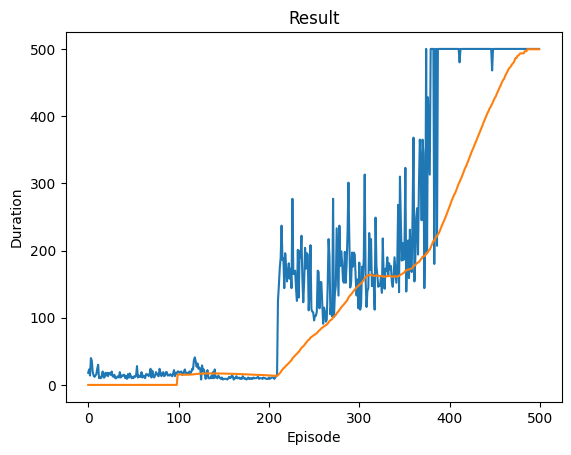

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [117]:
# make a new environment
init_env = gym.make('CartPole-v1', render_mode='rgb_array')
folder_name = os.path.join('video', 'CartPole-v1', f'{uuid.uuid4()}')
env = RecordVideo(init_env, folder_name, disable_logger=True)

# call the training loop
train_loop(env, 500)

# close the environment
env.close()

In [118]:
show_video(folder_name, episode = 'first')

In [119]:
show_video(folder_name, episode = 'last')

## Question 2 &emsp; <span style="color:green">(1 Point)</span>
Has the model learned? What metrics did you use to determine that?

<span style="color:green">Answer</span>

<span style="color:red">
Yes the model learned.

The metric I used to determine that is the increased duration in the later episodes.
</span>

## Question 3 (Understanding the code)&emsp; <span style="color:green">(6 Points Total)</span>
Hint: Use this as reference -> https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

3A. Copy and paste the section of the code where the epsilon greedy algorithm is implemented. Use 3 backticks (```) above and below code to denote code blocks. &emsp; <span style="color:green">(1 Point)</span>

<span style="color:green">Answer</span>

```
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
```

3B. Line-by-line explain in your own words how this code works. Remember that you can use backticks "\`" to denote `code`.&emsp; <span style="color:green">(2 Points)</span>

<span style="color:green">Answer</span>

<span style="color:red">

1. `global steps_done`

Access the global variable `steps_done`

2. `sample = random.random()`

Initialize sample a random number from 0-1.

3. `eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)`

Calculate the threshold for the greedy epsilon algorithm.

+1 extra credit if they explain how the individual terms work in the algorithm and note that the threshold is higher and close to `EPS_START`when `steps_done` is 0 or low and the threshold is lower and close to `EPS_END` when `steps_done` is larger.

4. `steps_done += 1`

Increment the number of steps done.

5. 
```
if sample > eps_threshold:
    with torch.no_grad():
        # t.max(1) will return the largest column value of each row.
        # second column on max result is index of where max element was
        # found, so we pick action with the larger expected reward.
        return policy_net(state).max(1).indices.view(1, 1)
```

If the random number is greater than the threshold, choose an action according to `policy_net` a.k.a exploitation.

6. 
```
else:
    return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
```

If the random number is less than the threshold, choose a random action in the action space a.k.a exploration.
</span>

3C. Copy and paste the section of the code where the expected Q Values are calculated. Use 3 backticks (```) above and below code to denote code blocks.&emsp; <span style="color:green">(1 Point)</span>

<span style="color:green">Answer</span>

```
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
```

3D. Line-by-line explain in your own words how this code works. Remember that you can use backticks "\`" to denote `code`.&emsp; <span style="color:green">(2 Points)</span>

<span style="color:green">Answer</span>

<span style="color:red">

1.
```
# Compute Q(s_t, a) - the model computes Q(s_t), then we select the
# columns of actions taken. These are the actions which would've been taken
# for each batch state according to policy_net
state_action_values = policy_net(state_batch).gather(1, action_batch)
```

Pass the state batch into the policy net. This returns the predicted best actions given the states, and calculates $Q(s_t, a)$ (The former Q-Value Estimation).

2.
```
# Compute V(s_{t+1}) for all next states.
# Expected values of actions for non_final_next_states are computed based
# on the "older" target_net; selecting their best reward with max(1).values
# This is merged based on the mask, such that we'll have either the expected
# state value or 0 in case the state was final.
next_state_values = torch.zeros(BATCH_SIZE, device=device)
```

Create a zero tensor the size of `BATCH_SIZE`.

3.
```
with torch.no_grad():
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
```

Pass the `non_final_next_states` into the target net this returns the predicted values for the next time step.


4.
```
# Compute the expected Q values
expected_state_action_values = (next_state_values * GAMMA) + reward_batch
```

Multiply the `next_state_values` by `GAMMA` (the discount rate) and add the `reward_batch` (the immediate reward) to calculate the `expected_state_action_values` (the TD Target).

5.
```
# Compute Huber loss
criterion = nn.SmoothL1Loss()
loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
```

Pass the TD Target and Former Q-Value Estimation into the loss function to calculate the loss (The TD Error).

6.
```
# Optimize the model
optimizer.zero_grad()
loss.backward()
# In-place gradient clipping
torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
optimizer.step()
```

Do a backward pass and perform gradient descent with AdamW optimizer which does so according to the learning rate. This essentially updates the model with New Q-Value Estimations.

If the student didn't match the lines of code to the terms in the Deep Q-Learning Pictures, make sure to note them for the student and take off half a point.
</span>

## Question 4 Changing Episode Length &emsp; <span style="color:green">(1 Point)</span>

Try different episode lengths. What happens when it is a lot shorter or a lot bigger?

Hint: [catastrophic forgetting/interference](https://en.wikipedia.org/wiki/Catastrophic_interference#:~:text=Catastrophic%20interference%2C%20also%20known%20as,information%20upon%20learning%20new%20information.) a.k.a. [catastrophic drop](https://ai.stackexchange.com/questions/28079/deep-q-learning-catastrophic-drop-reasons)

In [120]:
# Reinitialize Parameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0
episode_durations = []

Complete


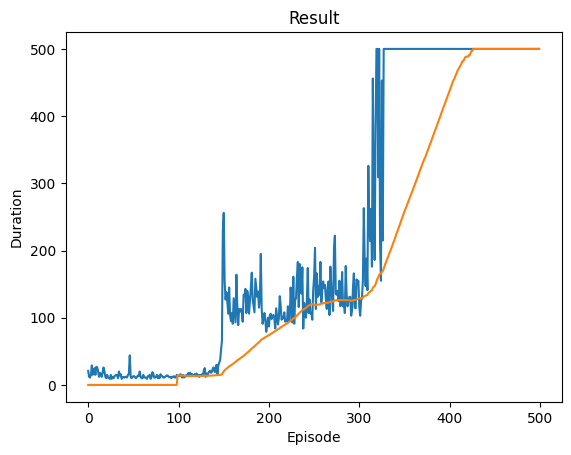

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [121]:
# make a new environment
init_env = gym.make('CartPole-v1', render_mode='rgb_array')
folder_name = os.path.join('video', 'CartPole-v1', f'{uuid.uuid4()}')
env = RecordVideo(init_env, folder_name, disable_logger=True)

# call the training loop
train_loop(env, 500)  # Edit this!!!

# close the environment
env.close()

<span style="color:green">Answer</span>

<span style="color:red">

1. At short episode lengths the model isn't able to do enough training loops to learn. This can be seen by the low duration when the episode length is low.

2. At long episode lengths the model can experience catastrophic forgetting which is when the duration suddenly drops and the model stops learning. 

    2. Alternative acceptable answer: They aren't able to get catastrophic forgetting to happen and they say that at long durations the duration stays high at 500 because a termination condition is if the episode length is greater than 500, and thus the model can't get better than that.
</span>

## Question 5 Manipulating the Reward&emsp; <span style="color:green">(10 Points Total)</span>

Using [Gymnasium Reward Wrapper](https://gymnasium.farama.org/api/wrappers/reward_wrappers/) manipulate the reward in various ways.

5.1 Set the reward to -1 then run the training loop again. What happens? Why is that?&emsp; <span style="color:green">(1 Point)</span>

In [122]:
##### Answer #####
from gymnasium.wrappers import TransformReward

Complete


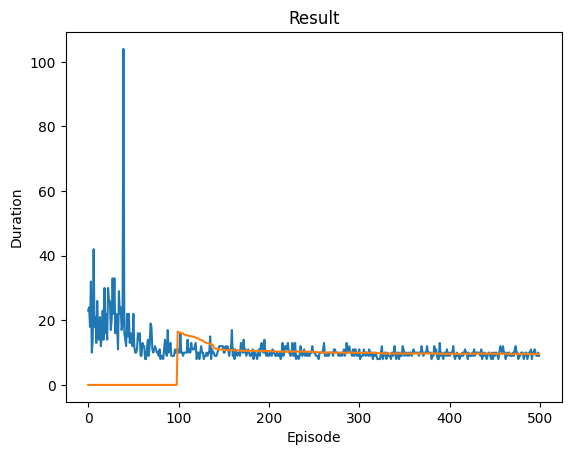

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [123]:
##### Answer #####

# Reinitialize Parameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0
episode_durations = []

# make a new environment
init_env = gym.make('CartPole-v1', render_mode='rgb_array')
init_env = TransformReward(init_env, lambda r: -1*r)
folder_name = os.path.join('video', 'CartPole-v1', f'{uuid.uuid4()}')
env = RecordVideo(init_env, folder_name, disable_logger=True)

# call the training loop
train_loop(env, 500)  # Edit this!!!

# close the environment
env.close()

In [124]:
show_video(folder_name, episode = 'last')

<span style="color:green">Answer</span>

![Local Image](student_created_graphs/reward_negative_one.png)

Example plot: Students aren't required to put a plot here this time, but next year they should be.

<span style="color:red">
The model has an initial spike in duration but overtime evens out around 10 duration. I hypothesize that because of the negative reward the pole tries to fall as fast as possible, but 10 is the fastest it can fall.
</span>

5.2 Set the reward to go from 1 every timestep, to -50 after 100 (change to 300) timesteps. What changes in behavior does this cause in the actor? Why is that?&emsp; <span style="color:green">(2 Point)</span>

Complete


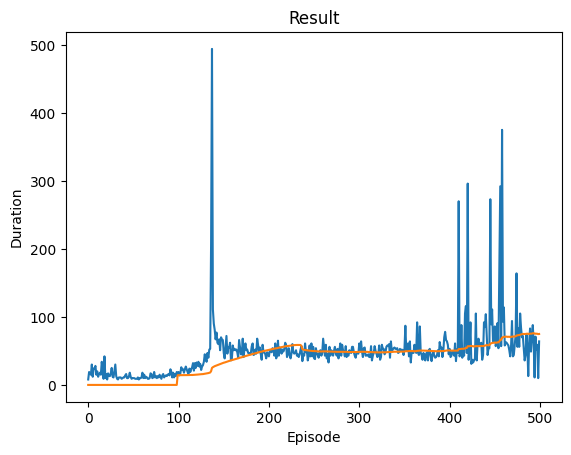

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [125]:
##### Answer #####

# Reinitialize Parameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0
episode_durations = []

# define reward function
counter = 0
def reward_function(r):
    global counter
    if counter < 100:
        counter += 1
        new_reward = r
    else:
        counter += 1
        new_reward = r * -50
    # print(counter, new_reward)
    return new_reward

# make a new environment
init_env = gym.make('CartPole-v1', render_mode='rgb_array')
init_env = TransformReward(init_env, lambda r: reward_function(r))
folder_name = os.path.join('video', 'CartPole-v1', f'{uuid.uuid4()}')
env = RecordVideo(init_env, folder_name, disable_logger=True)

# edit train_loop function to reset counter every time the episode ends
def train_loop(environment, episodes):

    num_episodes = episodes
    env = environment

    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        for t in count():
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())

            # Uncomment to print reward
            # print('time step:', t, 'reward:', reward)

            # Uncomment to print observation
            # print('time step:', t, 'observation:', observation)
            
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                plot_durations()
                global counter
                counter = 0
                break

    print('Complete')
    plot_durations(show_result=True)
    plt.ioff()
    plt.show()

# call the training loop
train_loop(env, 500)  # Edit this!!!

# close the environment
env.close()

In [126]:
show_video(folder_name, episode = 'last')

<span style="color:green">Answer</span>

![Local Image](student_created_graphs/reward_negative_fifty_after_hundred.png)

Students aren't required to put a plot here this time, but next year they should be.

<span style="color:red">

Because the reward is -50 after 100, the model duration increases passed 100 on some durations, but will come back down to around 50. It doesn't stablize near 100 but instead below 100 because it wants maximum reward, but not at the chance of hitting that -50 reward threshold. (If you think about it like a reward that penalize hitting a wall, it is avoiding the wall) Optional (do not take points off for not having): Later on the model sometimes increases catatrophic interference instead of stabilizing around 100 durations.

Note for graders regarding the code: When I was helping the students I didn't realize we needed to reset the counter at the end of each episode. So there will be some that just omit that part or turn it to -50 after 100 episodes not 100 timesteps. For Spring '24 lets still give full credit for code and graph analysis that does that, just note the correct solution along side it.Also next time change the question to 300 timesteps instead of 100 to make the effect more noticeable. 

Note 2: Also next year we should change it so that they have to start adding graphs in earlier questions as it is easier to have them analyze a specific graph as the the training behavior is not the same everytime. Its either that or we need to hold the seed constant for the random functions.

</span>

5.3.1 Currently we only are printing out the duration/iteration number. Before the environment-action loop initialize a variable `record_reward = []`, then during the loop append the reward after each action. Than after each episode you append the `record_reward` list to another new list called `episode_reward_hist`. Using that list of lists, create graphs comparing the normal reward, zero reward, and negative after 100 reward with `matplotlib`. Episode should be on the x-axis and Cumulative Reward (for each episode) on the y-axis. Make sure to label the axes, give the plots a title. After that, create another graph that takes the reward histories of all 3 reward policies and compares them on one graph, make sure to include a legend for this. 

(At least 4 graphs: 3 for each reward policy and 1 comparison graph of all three)

`matplotlib docs` -> https://matplotlib.org/stable/

<span style="color:green">(2 Points)</span>

Complete


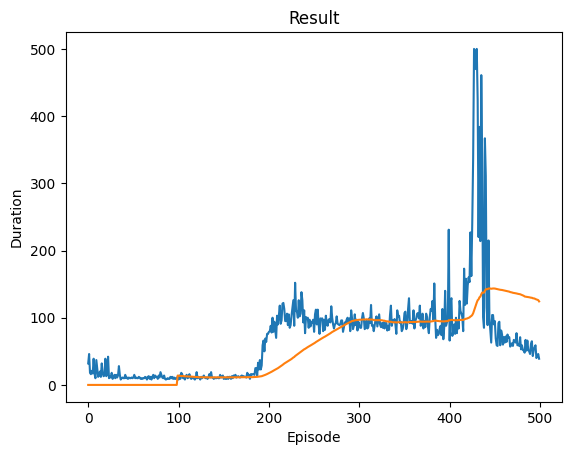

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [127]:
##### Answer #####

# Reinitialize Parameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0
episode_durations = []

# define reward function
counter = 0
def reward_function(r):
    global counter
    if counter < 100:
        counter += 1
        new_reward = r
    else:
        counter += 1
        new_reward = r * -50
    # print(counter, new_reward)
    return new_reward

# make a new environment
init_env = gym.make('CartPole-v1', render_mode='rgb_array')
folder_name = os.path.join('video', 'CartPole-v1', f'{uuid.uuid4()}')
env = RecordVideo(init_env, folder_name, disable_logger=True)

# edit train_loop function to reset counter every time the episode ends
def train_loop(environment, episodes):

    num_episodes = episodes
    env = environment
    
    #### ADDED CODE FOR THIS QUESTION ####
    normal_episode_reward_hist = []

    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        #### ADDED CODE FOR THIS QUESTION ####
        record_reward = []

        for t in count():
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())

            #### ADDED CODE FOR THIS QUESTION ####
            record_reward.append(reward)


            # Uncomment to print reward
            # print('time step:', t, 'reward:', reward)

            # Uncomment to print observation
            # print('time step:', t, 'observation:', observation)
            
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                plot_durations()
                global counter
                counter = 0
                break
        
        #### ADDED CODE FOR THIS QUESTION ####
        normal_episode_reward_hist.append(record_reward)

    print('Complete')
    plot_durations(show_result=True)
    plt.ioff()
    plt.show()

    #### ADDED CODE FOR THIS QUESTION ####
    return normal_episode_reward_hist

# call the training loop
normal_episode_reward_hist = train_loop(env, 500)  # Edit this!!!

# close the environment
env.close()

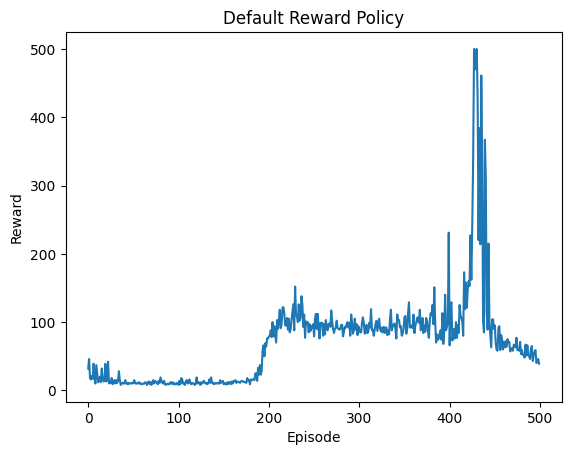

In [128]:
##### Answer #####
summed_norm_hist = [sum(x) for x in normal_episode_reward_hist]

plt.plot(summed_norm_hist)
plt.title('Default Reward Policy')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

Complete


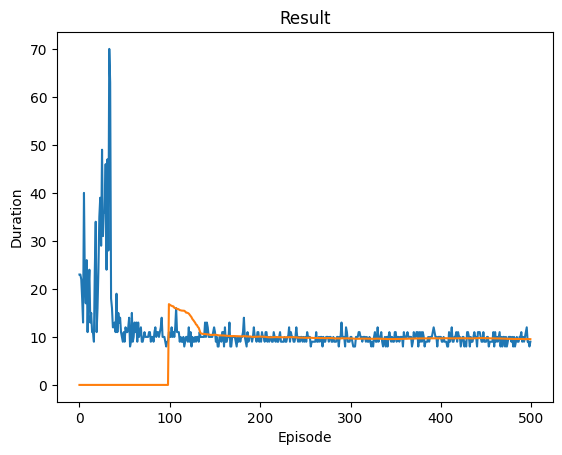

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [129]:
##### Answer #####

# Reinitialize Parameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0
episode_durations = []

# make a new environment
init_env = gym.make('CartPole-v1', render_mode='rgb_array')
init_env = TransformReward(init_env, lambda r: -1 * r)
folder_name = os.path.join('video', 'CartPole-v1', f'{uuid.uuid4()}')
env = RecordVideo(init_env, folder_name, disable_logger=True)

# edit train_loop function to reset counter every time the episode ends
def train_loop(environment, episodes):

    num_episodes = episodes
    env = environment
    
    #### ADDED CODE FOR THIS QUESTION ####
    negative_one_episode_reward_hist = []

    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        #### ADDED CODE FOR THIS QUESTION ####
        record_reward = []

        for t in count():
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())

            #### ADDED CODE FOR THIS QUESTION ####
            record_reward.append(reward)


            # Uncomment to print reward
            # print('time step:', t, 'reward:', reward)

            # Uncomment to print observation
            # print('time step:', t, 'observation:', observation)
            
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                plot_durations()
                global counter
                counter = 0
                break
        
        #### ADDED CODE FOR THIS QUESTION ####
        negative_one_episode_reward_hist.append(record_reward)

    print('Complete')
    plot_durations(show_result=True)
    plt.ioff()
    plt.show()

    #### ADDED CODE FOR THIS QUESTION ####
    return negative_one_episode_reward_hist

# call the training loop
negative_one_episode_reward_hist = train_loop(env, 500)  # Edit this!!!

# close the environment
env.close()

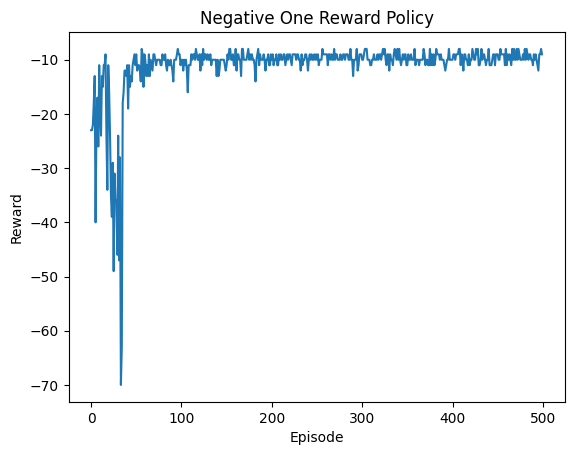

In [130]:
##### Answer #####
summed_norm_hist = [sum(x) for x in negative_one_episode_reward_hist]

plt.plot(summed_norm_hist)
plt.title('Negative One Reward Policy')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

Complete


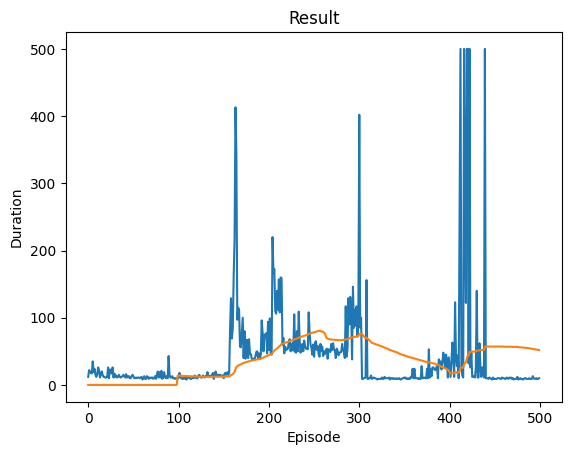

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [131]:
##### Answer #####

# Reinitialize Parameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0
episode_durations = []

# define reward function
counter = 0
def reward_function(r):
    global counter
    if counter < 100:
        counter += 1
        new_reward = r
    else:
        counter += 1
        new_reward = r * -50
    # print(counter, new_reward)
    return new_reward

# make a new environment
init_env = gym.make('CartPole-v1', render_mode='rgb_array')
init_env = TransformReward(init_env, lambda r: reward_function(r))
folder_name = os.path.join('video', 'CartPole-v1', f'{uuid.uuid4()}')
env = RecordVideo(init_env, folder_name, disable_logger=True)

# edit train_loop function to reset counter every time the episode ends
def train_loop(environment, episodes):

    num_episodes = episodes
    env = environment
    
    #### ADDED CODE FOR THIS QUESTION ####
    negative_fifty_after_hundred_episode_reward_hist = []

    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        #### ADDED CODE FOR THIS QUESTION ####
        record_reward = []

        for t in count():
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())

            #### ADDED CODE FOR THIS QUESTION ####
            record_reward.append(reward)


            # Uncomment to print reward
            # print('time step:', t, 'reward:', reward)

            # Uncomment to print observation
            # print('time step:', t, 'observation:', observation)
            
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                plot_durations()
                global counter
                counter = 0
                break
        
        #### ADDED CODE FOR THIS QUESTION ####
        negative_fifty_after_hundred_episode_reward_hist.append(record_reward)

    print('Complete')
    plot_durations(show_result=True)
    plt.ioff()
    plt.show()

    #### ADDED CODE FOR THIS QUESTION ####
    return negative_fifty_after_hundred_episode_reward_hist

# call the training loop
negative_fifty_after_hundred_episode_reward_hist = train_loop(env, 500)  # Edit this!!!

# close the environment
env.close()

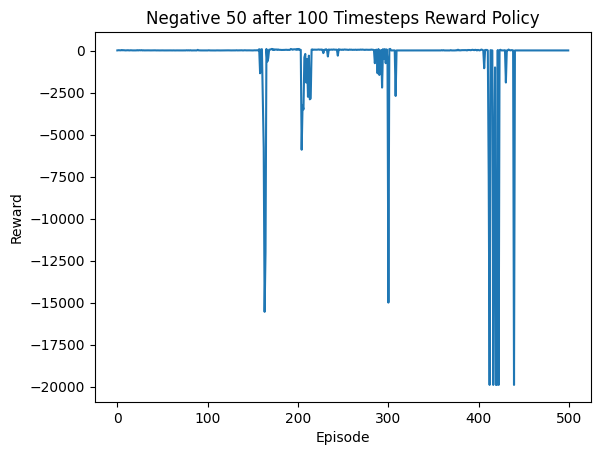

In [132]:
##### Answer #####
summed_norm_hist = [sum(x) for x in negative_fifty_after_hundred_episode_reward_hist]

plt.plot(summed_norm_hist)
plt.title('Negative 50 after 100 Timesteps Reward Policy')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

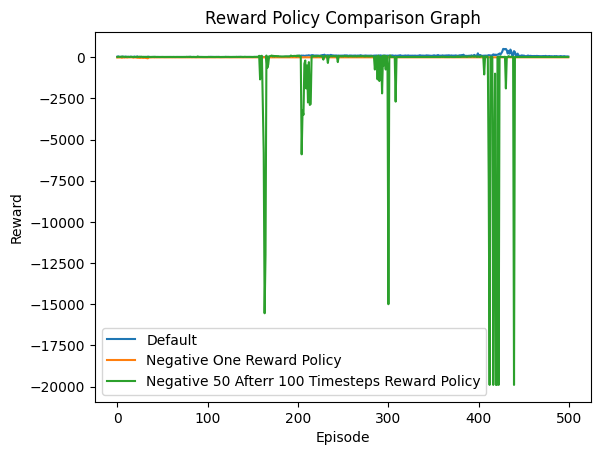

In [133]:
##### Answer #####
summed_1_hist = [sum(x) for x in normal_episode_reward_hist]
summed_2_hist = [sum(x) for x in negative_one_episode_reward_hist]
summed_3_hist = [sum(x) for x in negative_fifty_after_hundred_episode_reward_hist]

plt.plot(summed_1_hist, label='Default')
plt.plot(summed_2_hist, label='Negative One Reward Policy')
plt.plot(summed_3_hist, label='Negative 50 Afterr 100 Timesteps Reward Policy')
plt.title('Reward Policy Comparison Graph')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

5.3.2 Create a new folder called `student_created_graphs`. Save the graphs you made in 5.3.1 (and all graphs you use in answers going forth), place them in this new folder, then display them using markdown `![Description](student_created_graphs/your_graph.png)` in the cell below. &emsp; <span style="color:green">(1 Point)</span>

<span style="color:green">Answer</span>

![Description](student_created_graphs/Default_Reward_Policy.png)
![Description](student_created_graphs/Negative_50_after_100_Timesteps_Reward_Policy.png)
![Description](student_created_graphs/Negative_One_Reward_Policy.png)
![Description](student_created_graphs/Reward_Comparison.png)

5.4 Think of an interesting alternative reward transformation function that changes the behavior of the model in a noticeable way. What changed? Why did your modified reward cause this change? Make sure to display the plots/graphs you used to view this change. &emsp; <span style="color:green">(2 Points)</span>

In [134]:
##### Answer #####

## Any reward policy different then the ones before get 1 points ##

<span style="color:green">Answer</span>

<span style="color:red">
As long as they have one graph of the reward or the duration, 1 points.
</span>

5.5 Write a paragraph on how reward affects learning using what you've learned so far in this homework.&emsp; <span style="color:green">(2 Points)</span>

<span style="color:green">Answer</span>

<span style="color:red">

A positive reward encourages that behavior, a negative reward discourages that behavior. Plus a couple more sentences abouut the previous reward policies that is long enough to be a paragraph.

</span>

## Question 6 Manipulating the Observation&emsp; <span style="color:green">(5 Points Total)</span>

6.1 Using a Gymnasium [observation wrapper](https://gymnasium.farama.org/api/wrappers/observation_wrappers/) or directly zeroing out the indexes of the observation manipulate the observation so that the model can only see the angle of the pole. 

<span style="color:green">(2 Points)</span>

In [135]:
from gymnasium.wrappers import TransformObservation
import numpy as np

Complete


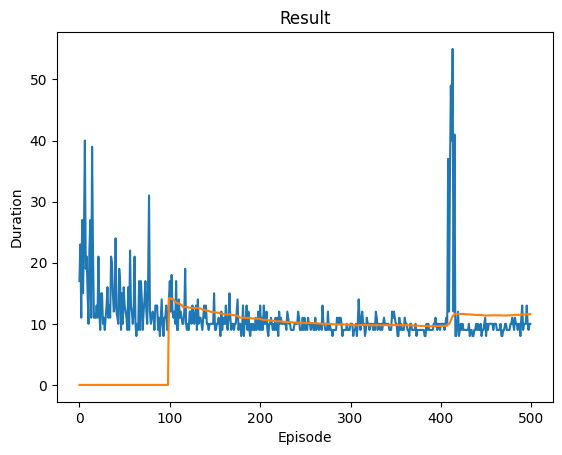

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [136]:
##### Answer #####

# Reinitialize Parameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0
episode_durations = []

# make a new environment
init_env = gym.make('CartPole-v1', render_mode='rgb_array')
init_env = TransformObservation(init_env, lambda obs: obs * np.array([0, 0, 1, 0]))
folder_name = os.path.join('video', 'CartPole-v1', f'{uuid.uuid4()}')
env = RecordVideo(init_env, folder_name, disable_logger=True)

# edit train_loop function to reset counter every time the episode ends
def train_loop(environment, episodes):

    num_episodes = episodes
    env = environment
    
    #### ADDED CODE FOR THIS QUESTION ####
    episode_reward_hist = []

    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        #### ADDED CODE FOR THIS QUESTION ####
        record_reward = []

        for t in count():
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())

            #### ADDED CODE FOR THIS QUESTION ####
            record_reward.append(reward)


            # Uncomment to print reward
            # print('time step:', t, 'reward:', reward)

            # Uncomment to print observation
            # print('time step:', t, 'observation:', observation)
            
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                plot_durations()
                break
        
        #### ADDED CODE FOR THIS QUESTION ####
        episode_reward_hist.append(record_reward)

    print('Complete')
    plot_durations(show_result=True)
    plt.ioff()
    plt.show()

    #### ADDED CODE FOR THIS QUESTION ####
    return episode_reward_hist

# call the training loop
episode_reward_hist = train_loop(env, 500)  # Edit this!!!

# close the environment
env.close()

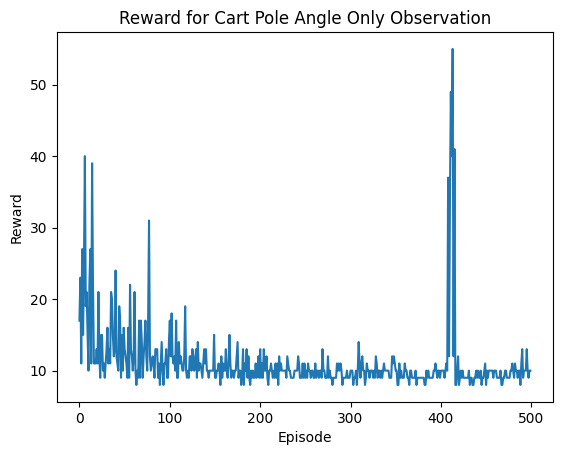

In [137]:
##### Answer #####
summed_hist = [sum(x) for x in episode_reward_hist]

plt.plot(summed_hist)
plt.title('Reward for Cart Pole Angle Only Observation')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

6.2 How does this affect learning (include graph)? &emsp; <span style="color:green">(1 Point)</span>

<span style="color:green">Answer</span>

![Description](/workspaces/WetAI-Reinforcement-Learning/student_created_graphs/Obs_Manip_Duration.png)

<span style="color:red">

The model isn't able to learn as the cart pole angle by itself isn't enoughh for the model to learn which moves are good. This can be seen in the duration graph where the the episode duration on average is around 10, which we learned in the -1 reward condition is the pole falling almost immediately.

</span>

6.3 In theory, how should increasing/decreasing the obervation space affect learning? The current observations we are feeding to the model clearly include useful information. Are all observations equally useful? Could we theoretically add a useless observation? What are the tradeoffs of adding more observations? &emsp; <span style="color:green">(1 Point)</span>

<span style="color:green">Answer</span>

<span style="color:red">

In theory increasing the observation space should increase the ability for the model to learn. However, increasing the space too much could make it hard for the model to know which observations are more important than the other. Not, all observations are equally useful. One could include the color of the cart pole to the observation space for instance to the model which would be useless information to the current task. Adding more observations makes it hard for the model to know which observations are useful, and you may need a bigger model. (Just need to include one tradeiff if adding more observations)

</span>

6.4 The current observation space is cart position, cart velocity, pole angle, and pole angular velocity. What if we changed the observation to the current frame, or a stack of frames of the environment? Reflect on in a single paragraph the benefits/detriments to doing this change, what factors are considered when choosing observations in general, and the importance of selecting a good observation space. &emsp; <span style="color:green">(2 Points)</span>

<span style="color:green">Answer</span>

<span style="color:red">
If we changed it to a stack of frames we would need to include each pixel as input to the model, this severely increases the observation space dimensions. This would likely hurt the model as the model would need to understand the position, velocity, angle, and angle velocity from the pixels alone. When choosing observations its important to select the most vital information from the environment to feed to the model to learn the the task if that is the goal. For example color doesn't matter in this task, but it might matter in a different task where the model has to moce the cart to an area of a certain color. If we don't select a good observation space the model will have a difficult time learning as it will have unnecessary information it is accounting for or it doesn't have the right information it needs to learn the task.


(Note: As long as a paragraph is written and all the questions are answered with reasonable answers that kind of line up with the above paragraph you can give full points)

</span>

6.5 Manipulating the observation changes what the model can see of the environment. What if we manipulate the environment itself? What could we change in the environment to make this cartpole task harder to learn what could we do to make it easier? &emsp; <span style="color:green">(1 Point)</span>

<span style="color:green">Answer</span>

<span style="color:red">
One thing we could do the make the cartpole task harder by changing the environment is by adding wind or changing the plane to sloped instead of flat that the cart needs to balance on. (The student can mention some other environmental obstruction that makes the task harder for points as well)
</span>

## Question 7 Spikes into Actions&emsp; <span style="color:green">(10 Points Total)</span>

In a future assigment instead of training a RL agent model, you will be training an organoid. As you learned in the electrophysiology homework, the output of an organoid is represented in spiketrains. 

Here is how to create a rate coded tensor by creating a tensor of probabilities and running a Bernouli trial over it:

In [138]:
# Temporal Dynamics
num_steps = 50

# create vector filled with 0.5
raw_vector = torch.ones(2, num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"Converted vector: {rate_coded_vector}")

print(f"The output is spiking {rate_coded_vector.sum()*100/torch.numel(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([[1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
         1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
         0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1.],
        [1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
         0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
         0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.]])
The output is spiking 43.00% of the time.


Here is how to concatenate multiple tensors to make a artificial spike train:

In [139]:
raw_vector_1 = torch.ones(2, num_steps)*0.8
raw_vector_2 = torch.ones(2, num_steps)*0.3
raw_vector_sum = torch.cat((raw_vector_1, raw_vector_2))
artificial_spike_train = torch.bernoulli(raw_vector_sum)
print(artificial_spike_train)
print(artificial_spike_train.size())

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
         0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
         1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.],
        [1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.]])
torch.Size([4, 50])


Here is how to visualize the artificial spike train with a raster plot using `spikeplot.raster` from `snnTorch`:

As you can see, "neurons" 0 and 1 are spiking 80% of the time, and "neurons" 2 and 3 are spiking 30% of the time.  

`spikeplot.raster` docs -> https://snntorch.readthedocs.io/en/latest/snntorch.spikeplot.html#snntorch.spikeplot.raster

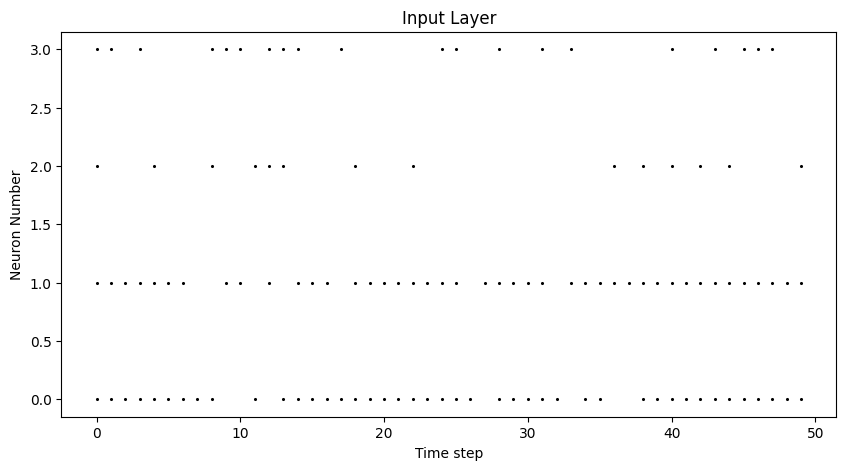

In [140]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)

# transpose the spike train so that time is the first dimension
artificial_spike_train = torch.transpose(artificial_spike_train, 0, 1)

#  s: size of scatter points; c: color of scatter points
splt.raster(artificial_spike_train, ax, s=1.5, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

7.1 Ratio Threshold Decoding &emsp; <span style="color:green">(2 Points)</span>

One way to decode spikes into actions is to choose a a ratio threshold where if the ratio of spikes is greater than that ratio choose one action and if it is below that ratio choose a different action. This could also be used to determine whether or not to do an action. 

Fill in the following function that takes in a spike train and a ratio threshold (0-1). The function should calculate the ratio between the sum of all the spikes and the number of time steps multiplied by the number of neurons. If that ratio is less than or equal to the ratio threshold push the cart left (action 0), else push the cart to the right (action 1).

In [141]:
def ratio_threshold(spike_train, ratio_threshold):
    ###### Answer #####
    
    spike_sum = torch.sum(spike_train)
    neurons = len(spike_train)
    time_steps = len(spike_train[0])
    ratio = spike_sum/(neurons * time_steps)

    if ratio <= ratio_threshold:
        action = 0
    else:
        action = 1
    return action

In [142]:
init_env = gym.make('CartPole-v1', render_mode='rgb_array')

folder_name = os.path.join('video', 'CartPole-v1', f'{uuid.uuid4()}')

# Use the wrapper environment RecordVideo() to record video
env = RecordVideo(init_env, folder_name, disable_logger=True)

observation, info = env.reset()

for _ in range(1000):
    new_spike_train = torch.bernoulli(
        torch.cat((
            torch.ones(2,num_steps) * 0.5,
            torch.ones(2, num_steps) * 0.3
        ))
    )
    action = ratio_threshold(new_spike_train, 0.5)
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

show_video(folder_name)

In [143]:
# Delete the videos

# Check if the directory exists
if os.path.exists(folder_name):
    # Remove the directory
    shutil.rmtree(folder_name)
    print("Directory deleted successfully.")
else:
    print("Directory does not exist.")

Directory deleted successfully.


7.2 Neuron Comparison Decoding&emsp; <span style="color:green">(2 Points)</span>

One way to decode spikes into actions is to compare the density or sum of spikes of groups of selected neurons. Then you would compare the sum or density to decide on an action.

Fill in the following functions takes in a spike train and two lists indicating the neurons for the groups. The first function should compare spike sums, and the second function should compare spike density.

In [144]:
def sum_comparison(spike_train, group1, group2):
    ###### Answer #####
    
    group1_sum = torch.zeros(1)
    for num in group1:
        group1_sum += torch.sum(spike_train[num])

    group2_sum = torch.zeros(1)
    for num in group2:
        group2_sum += torch.sum(spike_train[num])

    if group1_sum > group2_sum:
        action = 0
    else:
        action = 1
        
    return action

In [145]:
def density_comparison(spike_train, group1, group2):
    ###### Answer #####

    group1_sum = torch.zeros(1)
    for num in group1:
        group1_sum += torch.sum(spike_train[num])

    group2_sum = torch.zeros(1)
    for num in group2:
        group2_sum += torch.sum(spike_train[num])

    group1_neurons = torch.tensor(len(group1))
    group1_time_steps = torch.tensor(len(spike_train[0]))
    group1_density = group1_sum / (group1_neurons + group1_time_steps)

    group2_neurons = torch.tensor(len(group2))
    group2_time_steps = torch.tensor(len(spike_train[0]))
    group2_density = group2_sum / (group2_neurons + group2_time_steps)

    if group1_density > group2_density:
        action = 0
    else:
        action = 1
    
    return action

In [146]:
init_env = gym.make('CartPole-v1', render_mode='rgb_array')

folder_name = os.path.join('video', 'CartPole-v1', f'{uuid.uuid4()}')

# Use the wrapper environment RecordVideo() to record video
env = RecordVideo(init_env, folder_name, disable_logger=True)

observation, info = env.reset()

for _ in range(1000):
    new_spike_train = torch.bernoulli(
        torch.cat((
            torch.ones(2,num_steps) * 0.5,
            torch.ones(2, num_steps) * 0.3
        ))
    )
    action = sum_comparison(new_spike_train, [0,1], [2,3])
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

show_video(folder_name)

In [147]:
# Delete the videos

# Check if the directory exists
if os.path.exists(folder_name):
    # Remove the directory
    shutil.rmtree(folder_name)
    print("Directory deleted successfully.")
else:
    print("Directory does not exist.")

Directory deleted successfully.


In [148]:
init_env = gym.make('CartPole-v1', render_mode='rgb_array')

folder_name = os.path.join('video', 'CartPole-v1', f'{uuid.uuid4()}')

# Use the wrapper environment RecordVideo() to record video
env = RecordVideo(init_env, folder_name, disable_logger=True)

observation, info = env.reset()

for _ in range(1000):
    new_spike_train = torch.bernoulli(
        torch.cat((
            torch.ones(2,num_steps) * 0.5,
            torch.ones(2, num_steps) * 0.3
        ))
    )
    action = sum_comparison(new_spike_train, [0,2], [1,3])
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

show_video(folder_name)

In [149]:
# Delete the videos

# Check if the directory exists
if os.path.exists(folder_name):
    # Remove the directory
    shutil.rmtree(folder_name)
    print("Directory deleted successfully.")
else:
    print("Directory does not exist.")

Directory deleted successfully.


In [150]:
init_env = gym.make('CartPole-v1', render_mode='rgb_array')

folder_name = os.path.join('video', 'CartPole-v1', f'{uuid.uuid4()}')

# Use the wrapper environment RecordVideo() to record video
env = RecordVideo(init_env, folder_name, disable_logger=True)

observation, info = env.reset()

for _ in range(1000):
    new_spike_train = torch.bernoulli(
        torch.cat((
            torch.ones(2,num_steps) * 0.5,
            torch.ones(2, num_steps) * 0.3
        ))
    )
    action = density_comparison(new_spike_train, [0], [1,2,3])
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

show_video(folder_name)

In [151]:
# Delete the videos

# Check if the directory exists
if os.path.exists(folder_name):
    # Remove the directory
    shutil.rmtree(folder_name)
    print("Directory deleted successfully.")
else:
    print("Directory does not exist.")

Directory deleted successfully.


7.3 Stochastic Spike Decoding&emsp; <span style="color:green">(2 Points)</span>

Instead of comparing the spike densities of groups of neurons, one could interpret the density of a subset of the spike train as a probability to take an action. 

Fill in the following function that takes in a spike train, and a list of neurons in a group. It then calculates the density of that group and then uses that probability to determine if the cart pole should move right (1). That is if the density is 0.9, there is a 90% chance the cart will be moved right, else move the cart left (0). 

Hint: You can use `random.random()` to generate a random number between 0.0 and 1.0.

In [152]:
def stochastic_spike_decoding(spike_train, group):
    ###### Answer #####
    group_sum = torch.zeros(1)
    for num in group:
        group_sum += torch.sum(spike_train[num])

    group_neurons = torch.tensor(len(group))
    group_time_steps = torch.tensor(len(spike_train[0]))
    group_density = group_sum / (group_neurons + group_time_steps)

    num_gen = random.random()

    if num_gen < group_density.item():
        action = 0
    else:
        action = 1

    return action

In [153]:
init_env = gym.make('CartPole-v1', render_mode='rgb_array')

folder_name = os.path.join('video', 'CartPole-v1', f'{uuid.uuid4()}')

# Use the wrapper environment RecordVideo() to record video
env = RecordVideo(init_env, folder_name, disable_logger=True)

observation, info = env.reset()

for _ in range(1000):
    new_spike_train = torch.bernoulli(
        torch.cat((
            torch.ones(2,num_steps) * 0.5,
            torch.ones(2, num_steps) * 0.3
        ))
    )
    action = stochastic_spike_decoding(new_spike_train, [0, 1, 2])
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

show_video(folder_name)

In [154]:
# Delete the videos

# Check if the directory exists
if os.path.exists(folder_name):
    # Remove the directory
    shutil.rmtree(folder_name)
    print("Directory deleted successfully.")
else:
    print("Directory does not exist.")

Directory deleted successfully.


7.4 Decode Into a Continuous Action Space&emsp; <span style="color:green">(1 Points)</span>

So far we have been working with binary descrete actions, but it is possible to not only have multiple actions but a continuous action space instead. For example, if you wanted to determine the degrees a agent controlling a top down character mouse should move. A continuous action space would include not just the 360 degree angles, but even the decimal points in between them. 

Create a function that takes in a spike train and outputs a angle from 0-360 a theoretical mouse should move by returning the product of density and 360.

In [155]:
def continuous_degrees_turned(spike_train):
    ##### Answer ######
    spike_sum = torch.sum(spike_train)
    neurons = len(spike_train)
    time_steps = len(spike_train[0])
    ratio = spike_sum/(neurons * time_steps)

    action = 360 * ratio.item()
    return action

In [156]:
angle = continuous_degrees_turned(artificial_spike_train)
print(angle)

216.00000858306885


7.5 Do it yourself!&emsp; <span style="color:green">(3 Points)</span>

Create your own spike decoding to action function by combining the various techniques we just showed you or something else entirely! Then show that it works as expected by feeding a spike train into it. We want you to be creative and think about how you will decode the spikes in the upcoming project.

In [157]:
##### Answer #####
#### Here is an example of a technique a student could have made but it could be anything that is different from the ones before ####

def first_spike(spike_train, group1, group2):
    ###### Answer #####

    group1_first_spike_index = None
    for num in group1:
        if group1_first_spike_index is None:
            spike_list = spike_train[num].tolist()
            group1_first_spike_index = spike_list.index(1)
        else:
            spike_list = spike_train[num].tolist()
            if spike_list.index(1) < group1_first_spike_index:
                group1_first_spike_index = spike_list.index(1)
        

    group2_first_spike_index = None
    for num in group2:
        if group2_first_spike_index is None:
            spike_list = spike_train[num].tolist()
            group2_first_spike_index = spike_list.index(1)
        else:
            spike_list = spike_train[num].tolist()
            if spike_list.index(1) < group2_first_spike_index:
                group2_first_spike_index = spike_list.index(1)

    if group2_first_spike_index > group1_first_spike_index:
        action = 0
    else:
        action = 1
    
    return action

In [158]:
init_env = gym.make('CartPole-v1', render_mode='rgb_array')

folder_name = os.path.join('video', 'CartPole-v1', f'{uuid.uuid4()}')

# Use the wrapper environment RecordVideo() to record video
env = RecordVideo(init_env, folder_name, disable_logger=True)

observation, info = env.reset()

for _ in range(1000):
    new_spike_train = torch.bernoulli(
        torch.cat((
            torch.ones(2,num_steps) * 0.5,
            torch.ones(2, num_steps) * 0.3
        ))
    )
    action = first_spike(new_spike_train, [0], [1,2,3])
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

show_video(folder_name)

In [159]:
# Delete the videos

# Check if the directory exists
if os.path.exists(folder_name):
    # Remove the directory
    shutil.rmtree(folder_name)
    print("Directory deleted successfully.")
else:
    print("Directory does not exist.")

Directory deleted successfully.


## Feedback (Optional)

This is a new homework for this quarter, plase provide feedback on things you think could be improved or even if you like it as is.

<span style="color:green">Answer</span>